In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import tqdm
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
import matplotlib.pyplot as plt 
import seaborn as sns
from numpy import *
from numpy import random
from numba import jit, types
from numba.typed import Dict
import tqdm


In [2]:
# 8 by 8 grid
N = 8

#### Generate some initial random grids of spins

In [3]:
init_random = np.random.random((N,N))
lattice_n = np.zeros((N, N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

init_random = np.random.random((N,N))
lattice_p = np.zeros((N, N))
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

In [4]:
N=8             # Linear size of 2D Ising model, lattice = N x N
flatness = 0.9  # The condition to reset the Histogarm when
                # min(Histogram) > average(Histogram)*flattness

N2=N*N          # Total number of lattice sites
Energies = (4*np.arange(N2+1)-2*N2).tolist()
Energies.pop(1)   # Energies Emin+4 and Emax-4 
Energies.pop(-2)  # are not possible, hence removing them!
# Maximum energy
E0 = Energies[-1]                         
# Index array which will give us position in the Histogram array from knowing the Energy
indE = -np.ones(E0*2+1, dtype=int)           
for i,E in enumerate(Energies): indE[E+E0]=i


In [5]:
from numpy import *
from numpy import random
from numba import jit

@jit(nopython=True)
def CalculateEnergy(lattice):
    """Calculate energy of configuration for the 2D Ising model"""
    N = lattice.shape[0]
    energy = 0
    for i in range(N):
        for j in range(N):
            spin = lattice[i, j]   # Spin, can be either +1 or -1
            neighbors = lattice[(i+1)%N, j] + lattice[i, (j+1)%N] + lattice[(i-1)%N, j] + lattice[i, (j-1)%N]
            energy += -spin * neighbors
    return energy / 2

def GenerateLattice(N):
    """Lattice Generator"""
    
    return np.array(np.sign(2*np.random.random((N,N))-1),dtype=int) 


def splitDeltaH(delta_H):
    size = len(delta_H)
    idx_list = [idx for idx, val in
                enumerate(delta_H) if val == -1]


    res = [delta_H[i: j] for i, j in
            zip([0] + idx_list, idx_list +
            ([size] if idx_list[-1] != size else []))]


    return res

def average_of_two_arrays(arr1, arr2):
    
    len_1, len_2 = len(arr1), len(arr2)
    larger_one = arr1 if len_1 > len_2 else arr2
    
    min_len = min(len(arr1), len(arr2))
    
    arr1 = arr1[:min_len]
    arr2 = arr2[:min_len]
    return [(a + b) / 2 for a, b in zip(arr1, arr2)]

In [6]:
latt = GenerateLattice(8)

In [7]:
latt

array([[-1,  1, -1, -1, -1, -1, -1,  1],
       [ 1,  1, -1,  1,  1, -1, -1,  1],
       [ 1,  1, -1,  1, -1, -1, -1, -1],
       [-1,  1,  1, -1, -1, -1, -1,  1],
       [ 1,  1, -1,  1, -1,  1, -1, -1],
       [ 1,  1,  1,  1,  1, -1, -1, -1],
       [ 1, -1,  1,  1, -1,  1, -1,  1],
       [-1,  1,  1, -1,  1, -1, -1,  1]])

In [8]:
@jit(nopython=True)
def RunWangLandau(Nitt,Energies,latt,indE):
    N   = len(latt)
    Ene = int(CalculateEnergy(latt))
    delta_H = []
    lnf_v = []
    #min,maximum energy
    Emin, Emax = Energies[0],Energies[-1]
    # Logarithm of the density of states
    lngE = zeros(len(Energies))
    # Histogram
    Hist = zeros(len(Energies))
    # modification factor
    lnf = 0.1  # f = exp(lnf)=e
    lnf_v.append(lnf)

    N2 = N*N
    for itt in range(Nitt):
        t = int(random.rand()*N2)
        (i, j) = (int(t/N), t%N)
        S = latt[i,j]
        WF = latt[(i+1)%N,j]+latt[i,(j+1)%N]+latt[(i-1)%N,j]+latt[i,(j-1)%N]
        Enew = Ene + int(2*S*WF) # the energy change if we flip the spin
        # P = g(E)/g(Enew) = exp(log(g(E))-log(g(Enew)))
        # P = exp(lngE(E)-lngE(Enew))
        lgnew = lngE[indE[Enew-Emin]]
        lgold = lngE[indE[Ene-Emin]]
        P = 1.0
        if lgold-lgnew < 0 : P=exp(lgold-lgnew)
        if P > random.rand():
            # accept the step
            latt[i,j] = -S
            Ene = Enew
        Hist[indE[Ene-Emin]] += 1
        lngE[indE[Ene-Emin]] += lnf
        mH = min(Hist)
        delta_H.append(sum(Hist - mH))
        if (itt+1) % 1000 == 0: # checking for flatness of the histogram
            aH = sum(Hist)/N2 # average

            if mH > aH*flatness:  # histogram is flat
                Hist = zeros(len(Hist))
                lnf /= 1.78
                
                delta_H.append(-1)
                lnf_v.append(lnf)
                #   print(itt, 'histogram is flat', mH, aH, 'f=', exp(lnf))
    return (delta_H,lnf_v, lngE, Hist, Energies, latt)


In [9]:
from numpy import random
Energies = (array(4*arange(-int(N*N/2),int(N*N/2)+1),dtype=int)).tolist()
Energies.pop(1)
Energies.pop(-2)
Energies = array(Energies)
Emin, Emax = Energies[0],Energies[-1]
#index array
indE = -ones(Emax+1-Emin, dtype=int)
for i,E in enumerate(Energies):
    indE[E-Emin]=i
    
# Ising lattice at infinite T
latt = GenerateLattice(N)


In [ ]:
n_simulation = 32
Nitt=500000000   # Total number of Monte Carlo steps
delta_H, lnf_v, lngE, Hist, Energies,lat = RunWangLandau(Nitt , Energies, latt, indE)
delta_H = splitDeltaH(delta_H)
general_delta = dict(zip(lnf_v, delta_H))
# for i in tqdm.tqdm(range(n_simulation)):
#     delta_H, lnf_v, lngE, Hist, Energies,lat = RunWangLandau(Nitt , Energies, latt, indE)
#     delta_H = splitDeltaH(delta_H)
#     c_res = dict(zip(lnf_v, delta_H))
#     for lnf in lnf_v:
#         if(lnf in general_delta):
#             general_delta[lnf] = average_of_two_arrays(general_delta[lnf], c_res[lnf]) 
#         else:
#             general_delta[lnf] = c_res[lnf] 


In [ ]:
idx = 5
lnf_v = list(general_delta.keys())
X = np.arange(len(general_delta[lnf_v[idx]]))

plt.plot(X, general_delta[lnf_v[idx]], label='Histogram')


plt.xlabel('Energy')
plt.legend(loc='best')
plt.show()


In [ ]:
selected_idx = [4, 8, 12, 16]

In [20]:
lnf_v = list(general_delta.keys())
# X = np.arange(len(general_delta[lnf_v[idx]]))


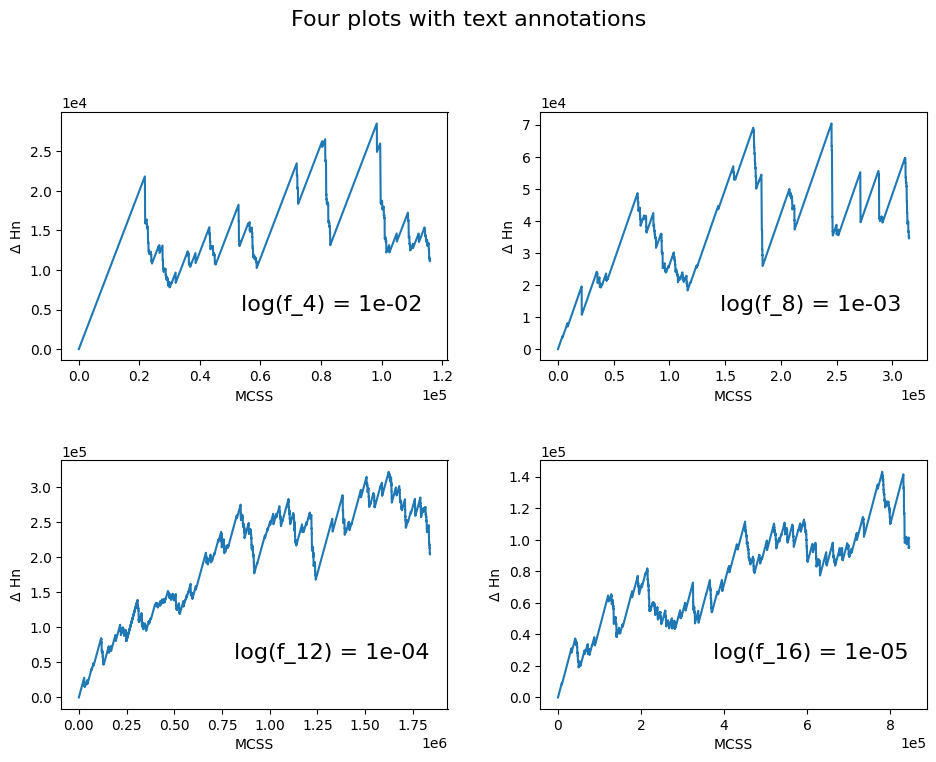

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Add scatter plots and text annotations in a loop
for i, ax in enumerate(axs.flatten()):
    idx = selected_idx[i]
    y = general_delta[lnf_v[idx]]
    X = np.arange(len(y))

    ax.plot(X, y)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))

    ax.set_ylabel("\u0394 Hn")
    ax.set_xlabel("MCSS")

#     ax.set_title(plot_titles[i])
    ax.text(0.7, 0.2, 'log(f_{}) = {:0.0e}'.format(idx, lnf_v[idx]), transform=ax.transAxes, fontsize=16, ha='center')

# Set main title
fig.suptitle("Four plots with text annotations", fontsize=16)

# Adjust layout
fig.tight_layout(pad=3)

# Show figure
plt.show()
